In [1]:
%matplotlib inline
import slug
import os
import glob
import h5py

import numpy as np

import matplotlib.pyplot as plt

from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column


from IPython.display import clear_output

In [2]:
os.chdir('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/MockTest/easy/HDF5/')
files = glob.glob('*')
os.chdir('..')

In [3]:
files

['MockGalaxy-002.h5',
 'MockGalaxy-003.h5',
 'MockGalaxy-004.h5',
 'MockGalaxy-000.h5',
 'MockGalaxy-001.h5']

### 1-D profile of mock image

In [4]:
index = files[0].lstrip('MockGalaxy-').rstrip('.h5')
sersic_index = 4

In [5]:
prefix = 's18a_bkg' + index + '_n' + str(sersic_index)
f = h5py.File('./HDF5/MockGalaxy-'+ index +'.h5')
img = f['MockImage']['n' + str(sersic_index)].value
w = wcs.WCS(f['background']['image_header'].value)
g4 = f.create_group('Mask')
g5 = f.create_group('MaskedImage')

('At redshift', 0.2, ', 1 arcsec =', 3.2996519002413693, 'kpc')
# Detect 85 objects


# Detect 134 objects
# Mean Sky / RMS Sky =    0.00361 /    0.06049


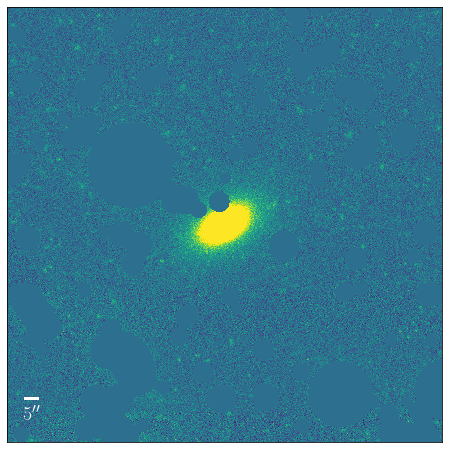

./Masks/s18a_bkg002_n4_msk.fits -> temp_72TUP.fits.pl
./Masks/s18a_bkg002_n4_msk.fits -> temp_72TUP.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  500 500
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/s18a_bkg002_n4_img.fits
###      Input Image   : temp_72TUP.fits
###      Output Binary : ./Images/s18a_bkg002_n4_img_ellip_2.bin
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
###  ELLIP

In [6]:
# phys_size
redshift = 0.2
phys_size = slug.phys_size(redshift)
# extract_obj
data = img

objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=5,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20,
    show_fig=False)
# make mask
seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)

objects, segmap = slug.extract_obj(data, b=30, f=5, sigma=3, pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1, deblend_nthresh=20, show_fig=False)
# make mask
seg_mask_2 = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
seg_mask = seg_mask + seg_mask_2

# evaluate_sky
bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)

f['info'][4] = 'global bkg', bkg_global.globalback
f['info'][5] = 'global rms', bkg_global.globalrms

g4.create_dataset('n' + str(sersic_index), data=seg_mask)
g5.create_dataset('n' + str(sersic_index), data=data*(~seg_mask))

# Save image and mask
if not os.path.isdir('Images'):
    os.mkdir('Images')
if not os.path.isdir('Masks'):
    os.mkdir('Masks')
img_fits = './Images/' + prefix + '_img.fits'
msk_fits = './Masks/' + prefix + '_msk.fits'
io.save_to_fits(data, img_fits, wcs=w)
io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)

display_single(data*(~seg_mask))
plt.show(block=False)
# Run ELLIPSE
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = slug.run_SBP(
    img_fits,
    msk_fits,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.1,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    outPre=prefix)
f['info'][6] = 'mean_e', ell_fix['ell'][10]
f['info'][7] = 'mean_pa', ell_fix['pa'][10]
f.create_dataset('ell_fix', data=ell_fix)
f.create_dataset('ell_free', data=ell_free)
f.close()

In [40]:
'''
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
redshift = 0.2
phys_size = slug.phys_size(redshift)
ell_free, ell_fix = slug.run_SBP(
    './ModelImage/img_model_n4.fits',
    None,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.1,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    outPre='model_n4')
clear_output()
'''

At redshift 0.2 , 1 arcsec = 3.29965190024 kpc
----------------------------------------------------------------------------------------------------
###      galX, galY :  600 600
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./ModelImage/img_model_n4.fits
###      Input Image   : temp_P0NW8.fits
###      Output Binary : ./ModelImage/img_model_n4_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###     1-D SBP background val

In [18]:
def print_attrs(name, obj):
    print name
    for key, val in obj.attrs.iteritems():
        print "    %s: %s" % (key, val)
f = h5py.File('./HDF5/MockGalaxy-002.h5', 'r')
f.visititems(print_attrs)
f['info'].value

Mask
Mask/n4
MaskedImage
MaskedImage/n4
MockImage
MockImage/n4
MockImage/n6
ModelImage
ModelImage/n4
ModelImage/n6
background
background/image
background/image_header
background/primary_header
background/variance
background/variance_header
ell_fix
ell_free
info


array([['edition', 's18a'],
       ['ra', '154.424746'],
       ['dec', '-1.7334625'],
       ['size (pix)', '1000'],
       ['global bkg', '0.00360502'],
       ['global rms', '0.06048927'],
       ['mean_e', '0.39'],
       ['mean_pa', '-59.89'],
       ['', ''],
       ['', '']], dtype='|S10')

Text(0.5,0.98,'$n=4$, \\texttt{easy}$\\mathrm{\\,mode}$')

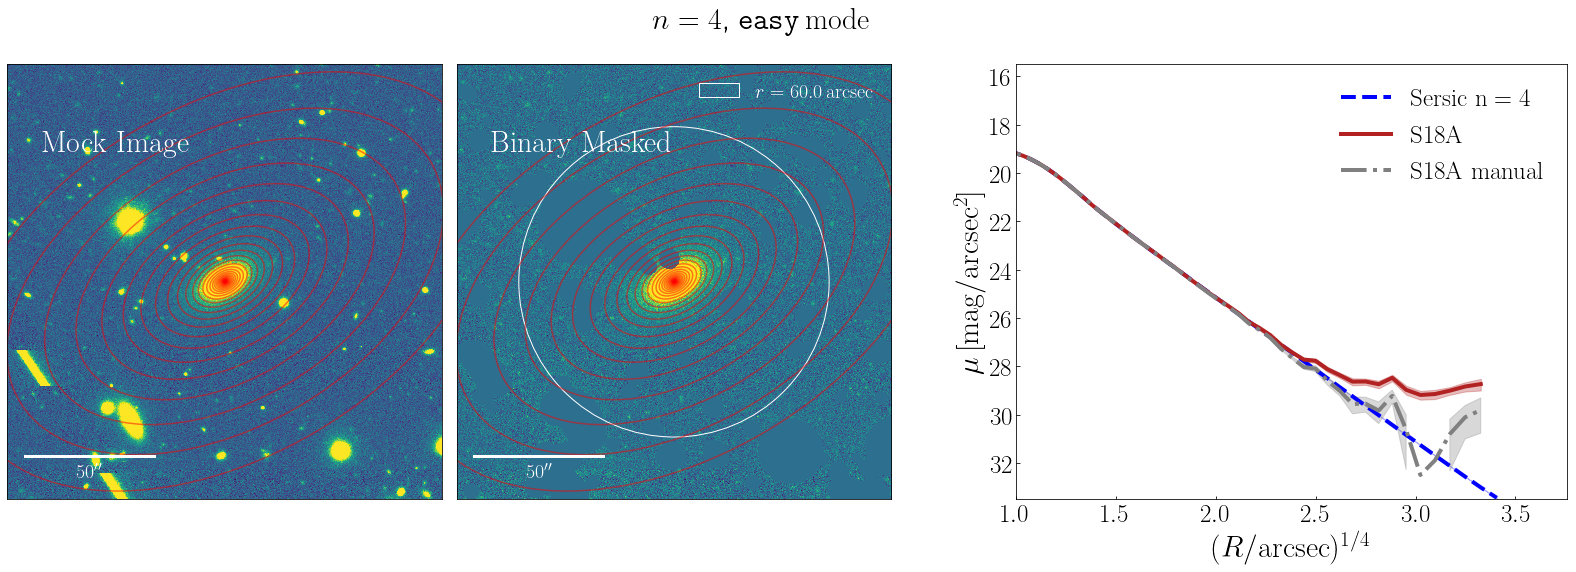

In [24]:
mock_s18a_ellipse_fix = f['ell_fix'].value

model_ellipse_fix = Table.read('./Data/model_n4-ellip-3.csv', format='csv')

img = f['MockImage']['n4'].value
masked_img = f['MaskedImage']['n4'].value

fig = plt.figure(figsize=(28, 8))
grid = plt.GridSpec(1, 14, wspace=0.1, hspace=0.1)

ax1 = fig.add_subplot(grid[0, 0:4])
ax1 = slug.display_isophote(
    img,
    mock_s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='Mock\ Image',
    ax=ax1)

ax2 = fig.add_subplot(grid[0, 4:8])
ax2 = slug.display_isophote(
    masked_img,
    mock_s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='Binary\ Masked',
    ax=ax2,
    circle=60)

ax3 = fig.add_subplot(grid[0, 9:])
ax3.tick_params(direction='in')

slug.SBP_single(
    model_ellipse_fix,
    0.2,
    slug.HSC_pixel_scale,
    slug.HSC_zeropoint,
    label='Sersic\ n=4',
    physical_unit=False,
    ax=ax3,
    linecolor='blue',
    linestyle='--',
    x_min=0,
    x_max=3.7)

slug.SBP_single(mock_s18a_ellipse_fix, 0.2, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3,
    physical_unit=False, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='firebrick',
    linestyle='-', label="S18A")
slug.SBP_single(
    mock_s18a_ellipse_fix, 0.2, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=-float(f['info'].value[4][1]),
    physical_unit=False, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='gray',
    linestyle='-.', label="S18A\ manual")


plt.ylim(15.5, 33.5)
#plt.vlines((100 * 0.168)**0.25, 15.5, 32.5, linestyle='-.', label='60 arcsec')
ax3.invert_yaxis()
plt.subplots_adjust(hspace=0.)
plt.suptitle(r'$n=4$, \texttt{easy}$\mathrm{\,mode}$', fontsize=30)

#plt.savefig('./Figures/' + prefix + '.png', dpi=100, bbox_inches='tight')